# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [7]:
# Importing some useful packages.
import pickle
import csv
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

from collections import Counter

# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


# Load the sign names
_SIGN_NAME_DICT = {}
with open('signnames.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        _SIGN_NAME_DICT[int(row['ClassId'])] = row['SignName']
        
def get_sign_name(label):
    return _SIGN_NAME_DICT.get(int(label))


# Set flags for feature engineering. Make sure we don't normalize the features more than once.
is_features_preprocessed = False
print('Data loaded.')

Data loaded.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

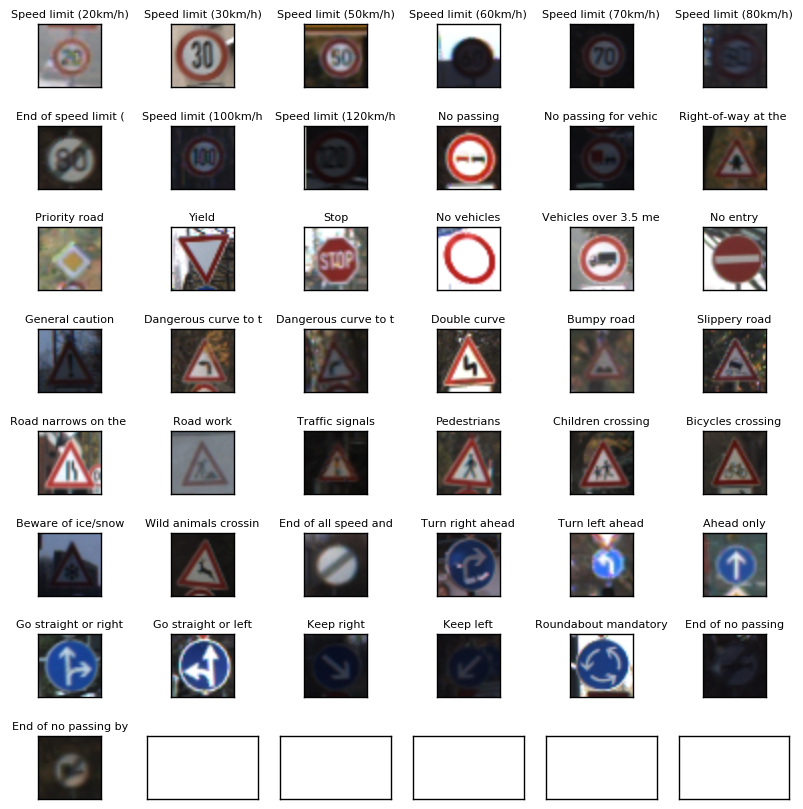

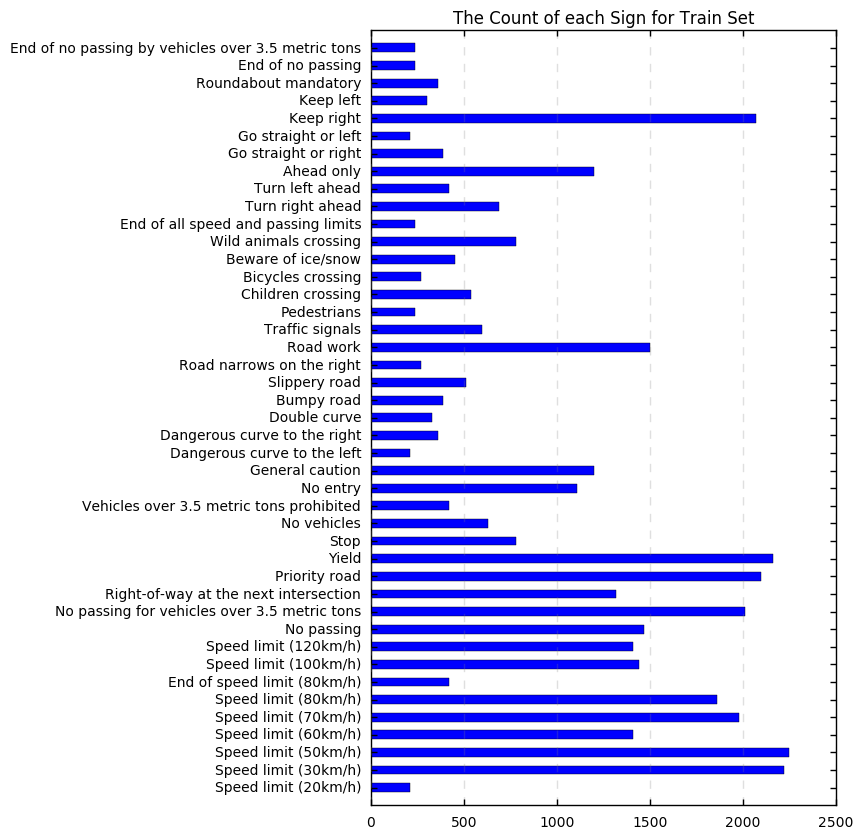

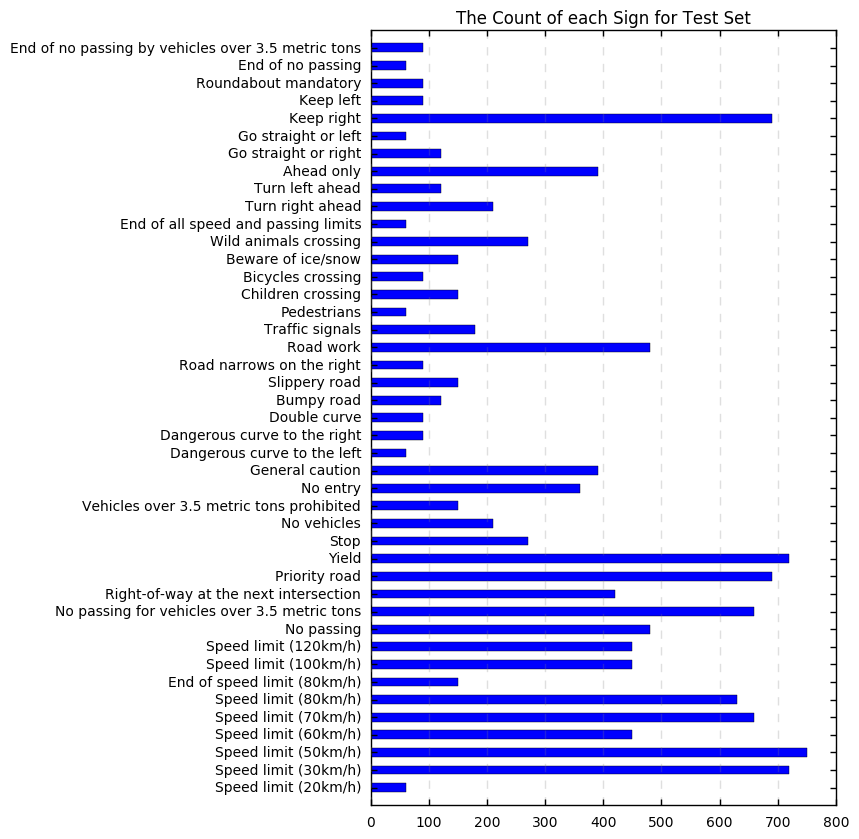

In [10]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.


# print(plt.style.available)
plt.style.use('seaborn-notebook')


def show_sign_image():
    """ Plotting the traffic sign images. """
    def find_image(label):
        """ Just use random index to find the label image. """
        if label not in y_train:
            return None
        
        while True:
            index = random.randint(0, n_train)
            if y_train[index] == label:
                return X_train[index]
            
    cols = 6
    fig, axes = plt.subplots(n_classes // cols + 1, ncols=cols, figsize=(10, 10))
    plt.setp(axes.flat, xticks=[], yticks=[])
    plt.subplots_adjust(hspace=0.618)
    for i, label in enumerate(set(y_train)):
        row = (i // cols)
        col = i % cols
        img = find_image(label)
        axes[row, col].imshow(img)
        axes[row, col].set_title(get_sign_name(label)[:20], size=8)


def show_sign_count(y_dataset, title='The Count of each Sign'):
    """ Plotting the count of each sign. """
    sign_counter = Counter(y_dataset)
    labels = []
    counts = []
    sign_names = []
    for label, count in sign_counter.items():
        labels.append(label)
        counts.append(count)
        sign_names.append(get_sign_name(label))

    fig, ax = plt.subplots(figsize=(6, 10))
    plt.title(title)
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    ax.set_ylim(min(labels) - 1, max(labels) + 1)
    plt.barh(labels, counts, align='center', height=0.5, color='b', tick_label=sign_names)
    plt.show()
    
    
# Plotting
show_sign_image()
show_sign_count(y_train, 'The Count of each Sign for Train Set')
show_sign_count(y_test, 'The Count of each Sign for Test Set')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def gray_scale(image_data):
    print(image_data)
    print(type(image_data))
    return np.vectorize(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY))(image_data)

def normalize_image(image_data):
    """
    Normailize the image data to a range of [-1, 1]
    """
    return (image_data - 127.5) / 127.5


def preprocess_image(image_data):
    # Change dtype and flatten data for pca or zca
    # image_data = image_data.astype(np.float32)
    # image_data = image_data.reshape((image_data.shape[0], -1))
    
    image_data = gray_scale(image_data)
    return image_data


def pca(data, percentage=0.99):
    """ Using PCA to lower the data's dimension. """
    
    def percentage2n(eig_vals, percentage):
        """ Choose principal component number """
        sort_array = np.sort(eig_vals)[-1::-1]
        sum_threshold = sum(sort_array) * percentage
        tmp_sum = 0
        num = 0
        for i in sort_array:
            tmp_sum += i
            num += 1
            if tmp_sum >= sum_threshold:
                return num
        
    cov_mat = np.cov(X_train, rowvar=0)
    eig_vals, eig_vects = np.linalg.eig(np.mat(cov_mat))
    n = percentage2n(eig_vals, 0.99)
    n_eig_val_indice = np.argsort(eig_vals)[-1:-(n+1):-1]
    n_eig_vects = eig_vects[:, n_eig_val_indice]

    low_dimension_data = X_train * n_eig_vects
    return low_dimension_data, n_eig_vects

def zca_whitening(data):
    # A 256 x 256 float64 covariance matrix would only need ~500kB
    sigma = np.cov(data, rowvar=True)
    U, S, V = np.linalg.svd(sigma)
    epsilon = 0.1
    zca_matrix = np.dot(np.dot(U, np.diag(1.0 / np.sqrt(S + epsilon))), U.T)
    return np.dot(zca_matrix, data)

if not is_features_preprocessed:
    X_train = preprocess_image(X_train)
    X_test = preprocess_image(X_test)
    is_features_preprocessed = True

[[[[ 75  78  80]
   [ 74  76  78]
   [ 83  84  83]
   ..., 
   [ 67  74  73]
   [ 65  69  68]
   [ 66  67  66]]

  [[ 82  83  85]
   [ 80  80  82]
   [ 87  86  83]
   ..., 
   [ 73  77  77]
   [ 75  77  75]
   [ 79  79  77]]

  [[ 79  79  81]
   [ 84  83  85]
   [ 91  88  89]
   ..., 
   [ 72  74  72]
   [ 74  75  71]
   [ 78  78  74]]

  ..., 
  [[126 128 133]
   [118 123 128]
   [108 117 120]
   ..., 
   [ 96  96  90]
   [ 99 101  94]
   [ 99 103  99]]

  [[ 90  94  98]
   [ 91  97 103]
   [ 77  87  92]
   ..., 
   [104 104  97]
   [107 111 102]
   [ 95 103  97]]

  [[ 85  84  87]
   [ 93  99 104]
   [ 69  80  85]
   ..., 
   [101 102  94]
   [ 98 101  90]
   [ 90  97  89]]]


 [[[ 69  73  73]
   [ 75  78  78]
   [ 75  77  77]
   ..., 
   [ 75  80  79]
   [ 70  76  76]
   [ 66  68  70]]

  [[ 65  69  69]
   [ 73  76  76]
   [ 82  82  81]
   ..., 
   [ 86  82  87]
   [ 73  78  82]
   [ 67  69  73]]

  [[ 63  68  68]
   [ 71  72  72]
   [ 80  78  77]
   ..., 
   [ 98  84  89]
   [ 71  

TypeError: src is not a numpy array, neither a scalar

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

First, I find and filter some idea that looks like be suitable for this project.
- Normalizing the dataset. In the lab of TensorFLow, the first step is normalizing features, but if we need to do the whitening, the mean of features should be zero, so I transform the features range from -1 to 1.
- PCA/ZCA Whitening.
  ZCA will cost lot of memory, so we need decrease the feature size or try the 1/f whitening. I will try this strategy later.
- [Breaking Linear Classifiers on ImageNet](http://karpathy.github.io/2015/03/30/breaking-convnets/)
- The features have 32x32x3 dimension, I think we can use a gray scale strategy for this dataset after observed the sign images. But I think the red color is very important in the traffic sign, so I'm thinking about calculate a red feature, calculate or use a machine learning, which is better? So I try to calculate and draw a plotting. 

In [ ]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**


- **Weights initialize strategy**: Make the initialize weights be in range [-b, b], with  
  (Hugo Larochelle)  
  $$b=\sqrt{\frac{6}{H_k+H_{k+1}}}$$
- Decrease learning rate.
- Use momentorn.

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.